In [1]:
%%html
<style>
img[alt=recurrent_unrolled] { width: 400px; }
</style>
<style>
img[alt=sequence_vector] { width: 400px; }
</style>
<style>
img[alt=gru-cell] { width: 400px; }
</style>
<style>
img[alt=encoder-decoder] { width: 400px; }
</style>

### Intro
* Use case: arbitrary-length **sequence** data analysis - *anticipation* abilities
* RNNs much like feed-forward NNs, but also with backward-facing connections
* At time step *t* each node sees input *x(t)* plus its previous output *y(t-1)*.
* Below: "unrolling" a net across a time axis.
![recurrent_unrolled](pics/recurrent-neurons-unrolled.png)


### Memory Cells
* A network node that preserves state across time is called a **cell** (memory cell).
* *h(t)* is a cell's "hidden" state at time=t.
![recurrent-memcells](pics/recurrent-memcells.png)

### Input/Output Sequences
* RNNs can be used to predict the results of time shifts (sequence-to-sequence), a sentiment score (sequence-to-vector), or image caption (vector-to-sequence).
* sequence-to-vector nets = **encoders**; vector-to-sequence nets = **decoders**. One use case: language translation.
* Below:
    * Top Left: Sequence-to-sequence
    * Top Right: Sequence-to-vector
    * Bot Left:  Vector-to-sequence
    * Bot Right: Delayed-sequence-to-sequence
![sequence_vector](pics/sequence-vector.png)

### Basic RNNs in TF
* RNN design: layer of **5 recurrent cells** with tanh activation; runs over **2** time steps, and uses **vectors of size=3** at each step.

In [2]:
import tensorflow as tf

n_inputs = 3
n_neurons = 5

# two-layer net

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons],dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons,n_neurons],dtype=tf.float32))

b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)

init = tf.global_variables_initializer()

In [3]:
# to feed inputs at both time steps,

import numpy as np
# Mini-batch: instance 0,instance 1,instance 2,instance 3

X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1

In [4]:
# Y0, Y1 = network outputs at both time steps

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})
    
print("output at t=0:\n",Y0_val,"\n","output at t=1\n",Y1_val)

output at t=0:
 [[-0.77183092 -0.99924457  0.23752896 -0.63130957 -0.83723265]
 [-0.92028087 -1.          0.99004787 -0.87230623 -0.99995315]
 [-0.97358704 -1.          0.999919   -0.95966864 -1.        ]
 [ 0.99999094 -0.99890459  0.9991411   0.99996841 -0.99999803]] 
 output at t=1
 [[ 0.99512661 -1.          0.99997395 -0.99830353 -1.        ]
 [ 0.99977976  0.99013239 -0.96352106 -0.99476629  0.97579277]
 [ 0.99981618 -0.99989575  0.99114233 -0.99827981 -0.99984008]
 [ 0.54805535 -0.84061396 -0.99912792 -0.47432473 -0.99921536]]


### Unrolling through Time (Static) using static_rnn()

In [5]:
tf.reset_default_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

# BasicRNNCell() -- memcell "factory"

basic_cell = tf.contrib.rnn.BasicRNNCell(
    num_units=n_neurons)

# static_rnn() -- creates unrolled RNN net by chaining cells.
# returns 1) python list of output tensors for each time step
#         2) tensor of final network states

output_seqs, states = tf.contrib.rnn.static_rnn(
    basic_cell, 
    [X0, X1], 
    dtype=tf.float32)

Y0, Y1 = output_seqs

init = tf.global_variables_initializer()

In [6]:
# to feed inputs at both time steps,

import numpy as np
# Mini-batch: instance 0,instance 1,instance 2,instance 3

X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1

In [7]:
# Y0, Y1 = network outputs at both time steps

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})
    
print("output at t=0:\n",Y0_val,"\n","output at t=1\n",Y1_val)

output at t=0:
 [[ 0.42442048  0.92431569 -0.2353479  -0.90074939 -0.94408685]
 [ 0.73783255  0.98977458 -0.72123086 -0.99919385 -0.99999249]
 [ 0.89336294  0.99865782 -0.9186905  -0.99999398 -1.        ]
 [-0.99143326 -0.99993676 -0.37607926  0.88796568 -0.99899191]] 
 output at t=1
 [[ 0.81709599  0.48319042 -0.96708876 -0.9998284  -1.        ]
 [-0.18962485 -0.81231028 -0.21763545  0.88739753  0.57306314]
 [ 0.17130674 -0.6411857  -0.86380148 -0.95413983 -0.99999553]
 [-0.07749119 -0.86547101 -0.00461033 -0.91877526 -0.99582738]]


### Simplification

In [8]:
tf.reset_default_graph()

n_steps = 2
n_inputs = 3
n_neurons = 5

# this time, use placeholder with add'l dimension for #timesteps
#X0 = tf.placeholder(tf.float32, [None, n_inputs])
#X1 = tf.placeholder(tf.float32, [None, n_inputs])
X =   tf.placeholder(tf.float32, [None, n_steps, n_inputs])

#print(X)

# transpose - make time steps = 1st dimension
# unstack - extract list of tensors

X_seqs = tf.unstack(
    tf.transpose(
        X, perm=[1, 0, 2]))

#print(X_seqs)

# BasicRNNCell() -- memcell "factory"

basic_cell = tf.contrib.rnn.BasicRNNCell(
    num_units=n_neurons)

# static_rnn() -- creates unrolled RNN net by chaining cells.
# returns 1) python list of output tensors for each time step
#         2) tensor of final network states

output_seqs, states = tf.contrib.rnn.static_rnn(
    basic_cell, 
    X_seqs, 
    dtype=tf.float32)

#Y0, Y1 = output_seqs

# stack - merge output tensors
# transpose - swap 1st two dimensions
# returns tensor shape [none, #steps, #neurons]

outputs = tf.transpose(
    tf.stack(output_seqs), 
    perm=[1,0,2])

init = tf.global_variables_initializer()

In [9]:
X_batch = np.array([
        # t = 0      t = 1 
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})
    
print(outputs_val)

[[[ 0.76157701  0.11581181  0.64773971 -0.79434019 -0.86054337]
  [ 0.99998951 -0.66595364  0.99812627 -1.          0.84574401]]

 [[ 0.99683905  0.29572889  0.98365188 -0.99992883 -0.88169324]
  [ 0.41841054 -0.92049074 -0.64612901 -0.73361856  0.29283327]]

 [[ 0.99996316  0.45685658  0.99936479 -1.         -0.89980829]
  [ 0.99907684 -0.87088716  0.94328976 -0.9999997   0.87934762]]

 [[ 0.12318966  0.02264917  0.99982244 -0.99998975  0.99996465]
  [ 0.9525854  -0.56515652  0.08665188 -0.99705428  0.87525886]]]


* Above code still not ideal - builds graph with one cell per time step. Ugly & can cause Out Of Memory errors.

### Unrolling through Time using dynamic_rnn()
* uses while_loop() to iterate over the memcell
* set swap_memory=True to move GPU memory to CPU during backprop if needed
* accepts single tensor, outputs single tensor - no stack/unstack/transpose ops required.

In [10]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(
    num_units=n_neurons)

outputs, states = tf.nn.dynamic_rnn(
    basic_cell, X, dtype=tf.float32)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})
    
print(outputs_val)

[[[ 0.01341763 -0.10483158 -0.94257653  0.83843452 -0.20272173]
  [ 0.99978089 -0.63150525 -0.99999148  0.99999386 -0.87993085]]

 [[ 0.94205797 -0.13386673 -0.9997741   0.99812031 -0.64444101]
  [-0.6134249  -0.55738503  0.39783546  0.89031053  0.04465704]]

 [[ 0.99817288 -0.16267382 -0.99999928  0.99997997 -0.86824256]
  [ 0.99097538 -0.61533296 -0.99695957  0.99986053 -0.64558744]]

 [[ 0.9963541   0.23641461  0.75174934  0.98267573 -0.97034496]
  [ 0.85169196 -0.07830215 -0.3604137   0.95550352  0.12307668]]]


### Variable-Length Input Sequences
* Most problems will have variable length inputs (like sentences).
* This option uses **sequence_length** param (1D tensor)

In [11]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

seq_length = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(
    num_units=n_neurons)

outputs, states = tf.nn.dynamic_rnn(
    basic_cell, X, dtype=tf.float32,
    #
    #
    sequence_length=seq_length)
    #
    #
X_batch = np.array([
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2 -- zero padded
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

seq_length_batch = np.array([2,1,2,2])

init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run(
        [outputs, states], 
        feed_dict={X: X_batch, seq_length: seq_length_batch})

# RNN should output zero vectors for any time step 
# beyond input sequence length
print(outputs_val)

[[[ 0.28581977 -0.77421445 -0.34181327 -0.87767971 -0.91387445]
  [ 0.99970448 -1.          0.79238343 -1.         -0.9997654 ]]

 [[ 0.96786171 -0.99937457 -0.03243476 -0.99988878 -0.99875116]
  [ 0.          0.          0.          0.          0.        ]]

 [[ 0.99903995 -0.99999839  0.28328663 -0.99999982 -0.99998271]
  [ 0.96896154 -0.99999189  0.43341497 -0.99996883 -0.98279852]]

 [[ 0.9976812  -0.99999118  0.99979782 -0.99983948  0.84931362]
  [ 0.57188803 -0.99268627 -0.30526906 -0.99518502  0.109933  ]]]


In [12]:
# states tensor contains final state of each cell
print(states_val)

[[ 0.99970448 -1.          0.79238343 -1.         -0.9997654 ]
 [ 0.96786171 -0.99937457 -0.03243476 -0.99988878 -0.99875116]
 [ 0.96896154 -0.99999189  0.43341497 -0.99996883 -0.98279852]
 [ 0.57188803 -0.99268627 -0.30526906 -0.99518502  0.109933  ]]


### Variable-Length Output Sequences
* Typical output sequence lengths not equal to input lengths
* Most common solution: use *end-of-sequence (EOS) token*.

### RNN Training
* Unroll through time (as shown above) then use backprop through time (*BPTT*).
![rnn_training](pics/rnn-training.png)

### RNN Training: Classifier
* Example: use MNIST (CNN would be better, but lets keep it simple)
* Treat images as 28 rows of 28 pixels each
* Use 150 rnn cells + fully-connected layer of 10 cells (1 per class)
* Followed by softmax layer
![sequence-classifier](pics/sequence-classifier.png)

In [13]:
# similar to MNIST classifier
# unrolled RNN replaces hidden layers

tf.reset_default_graph()

from tensorflow.contrib.layers import fully_connected

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10
learning_rate = 0.001

# y = placeholder for target classes

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(
    num_units=n_neurons)

outputs, states = tf.nn.dynamic_rnn(
    basic_cell, X, dtype=tf.float32)

logits = fully_connected(
    states, n_outputs, activation_fn=None)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
    labels=y, logits=logits)

loss = tf.reduce_mean(
    xentropy)

optimizer = tf.train.AdamOptimizer(
    learning_rate=learning_rate)

training_op = optimizer.minimize(
    loss)

correct = tf.nn.in_top_k(
    logits, y, 1)

accuracy = tf.reduce_mean(
    tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [14]:
# load MNIST data, reshape to [batch_size, n_steps, n_inputs]

from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("/tmp/data/")

X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [15]:
# ready to run. reshape each training batch before feeding to net.

n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape(
                (-1, n_steps, n_inputs))

            sess.run(
                training_op, 
                feed_dict={X: X_batch, y: y_batch})
            
        acc_train = accuracy.eval(
            feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(
            feed_dict={X: X_test, y: y_test})

        print(epoch, 
              "Train accuracy:", acc_train, 
              "Test accuracy:",  acc_test)

0 Train accuracy: 0.953333 Test accuracy: 0.8711
1 Train accuracy: 0.953333 Test accuracy: 0.9417
2 Train accuracy: 0.953333 Test accuracy: 0.9432
3 Train accuracy: 0.946667 Test accuracy: 0.9595
4 Train accuracy: 0.98 Test accuracy: 0.9627
5 Train accuracy: 0.966667 Test accuracy: 0.9666
6 Train accuracy: 0.96 Test accuracy: 0.961
7 Train accuracy: 0.973333 Test accuracy: 0.9729
8 Train accuracy: 0.986667 Test accuracy: 0.9702
9 Train accuracy: 0.986667 Test accuracy: 0.9732


### RNN Training: Predicting Time Series
![rnn-timeseries](pics/rnn-timeseries.png)

In [16]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

t = np.linspace(t_min, t_max, (t_max - t_min) // resolution)

n_steps = 20
t_instance = np.linspace(
    12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)


In [17]:
# each training instance = 20 inputs long
# targets = 20-input sequences

tf.reset_default_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.BasicRNNCell(
    num_units=n_neurons, 
    activation=tf.nn.relu)

outputs, states = tf.nn.dynamic_rnn(
    cell, X, dtype=tf.float32)

print(outputs.shape)

(?, 20, 100)


In [18]:
# output at each time step now vector[100],
# but we want single output value at each step.

# use OutputProjectionWrapper()
# -- adds FC layer to top of each output

cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(
        num_units=n_neurons, 
        activation=tf.nn.relu),
    output_size=n_outputs)

In [19]:
# define cost function using MSE
# use Adam optimizer

learning_rate = 0.001
loss = tf.reduce_mean(
    tf.square(outputs - y))

optimizer = tf.train.AdamOptimizer(
    learning_rate=learning_rate)

training_op = optimizer.minimize(loss)
init = tf.global_variables_initializer()

In [20]:
# initialize & run

init = tf.global_variables_initializer()
n_iterations = 1000
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)

    
    # use trained model to make some predictions
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    print(y_pred)

0 	MSE: 15.3099
100 	MSE: 13.5276
200 	MSE: 11.0956
300 	MSE: 9.91156
400 	MSE: 14.0311
500 	MSE: 9.73811
600 	MSE: 9.23351
700 	MSE: 9.64445
800 	MSE: 8.98904
900 	MSE: 10.849
[[[ 0.          0.          0.         ...,  0.          0.          0.        ]
  [ 0.          0.04218276  0.         ...,  0.          0.          0.        ]
  [ 0.          0.14342034  0.         ...,  0.          0.          0.        ]
  ..., 
  [ 6.67315388  0.          6.39087296 ...,  6.9017005   6.30435514
    6.23329258]
  [ 6.61708975  0.          6.31429434 ...,  6.58116341  6.19745445
    6.11896658]
  [ 5.9406209   0.          5.73649979 ...,  5.63920403  5.5386672
    5.47510672]]]


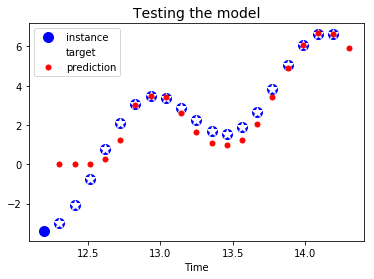

In [21]:
import matplotlib.pyplot as plt

plt.title("Testing the model", fontsize=14)

plt.plot(
    t_instance[:-1], 
    time_series(t_instance[:-1]), 
    "bo", markersize=10, label="instance")

plt.plot(
    t_instance[1:], 
    time_series(t_instance[1:]), 
    "w*", markersize=10, label="target")

plt.plot(
    t_instance[1:], 
    y_pred[0,:,0], 
    "r.", markersize=10, label="prediction")

plt.legend(loc="upper left")
plt.xlabel("Time")
#save_fig("time_series_pred_plot")
plt.show()

* **OutputProjectionWrapper()** = simplest solution for reducing output sequences to one value/timestep, but not most efficient.
* More efficient solution shown below - **signficant speed boost**.

In [22]:
tf.reset_default_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.BasicRNNCell(
    num_units=n_neurons, 
    activation=tf.nn.relu)

rnn_outputs, states = tf.nn.dynamic_rnn(
    cell, X, dtype=tf.float32)

# stack outputs using reshape
stacked_rnn_outputs = tf.reshape(
    rnn_outputs, [-1, n_neurons])

print(stacked_rnn_outputs)

# add FC layer -- just a projection, so no activation fn needed
stacked_outputs = fully_connected(
    stacked_rnn_outputs, 
    n_outputs,
    activation_fn=None)

print(stacked_outputs)

# unstack outputs using reshape
outputs = tf.reshape(
    stacked_outputs, [-1, n_steps, n_outputs])

print(outputs)

loss = tf.reduce_sum(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

#initialize & run
init = tf.global_variables_initializer()

n_iterations = 1000
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)

    
    # use trained model to make some predictions
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    print(y_pred)

Tensor("Reshape:0", shape=(?, 100), dtype=float32)
Tensor("fully_connected/BiasAdd:0", shape=(?, 1), dtype=float32)
Tensor("Reshape_1:0", shape=(?, 20, 1), dtype=float32)
0 	MSE: 22963.7
100 	MSE: 743.444
200 	MSE: 276.131
300 	MSE: 117.955
400 	MSE: 53.3529
500 	MSE: 63.4189
600 	MSE: 45.1415
700 	MSE: 41.5129
800 	MSE: 53.4219
900 	MSE: 43.2203
[[[-3.46527553]
  [-2.46867704]
  [-1.10144436]
  [ 0.69717044]
  [ 2.08823276]
  [ 3.13628578]
  [ 3.55210543]
  [ 3.4186697 ]
  [ 2.85978389]
  [ 2.15520501]
  [ 1.67705297]
  [ 1.6919663 ]
  [ 1.93633199]
  [ 2.70151305]
  [ 3.87054777]
  [ 5.11770582]
  [ 6.15701818]
  [ 6.71814394]
  [ 6.69798708]
  [ 6.08309698]]]


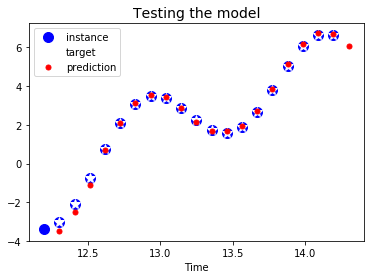

In [23]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.show()

### Creative RNNs
* Use model to generate creative sequences
* Provide seed sequence of length = n_steps, zero-filled
* use model to append predicted new value to sequence
* feed last n_steps values to model to predict next value, etc.
* should get new sequence resembling original time series

0 	MSE: 14607.1
100 	MSE: 505.605
200 	MSE: 167.29
300 	MSE: 83.1336
400 	MSE: 58.9695
500 	MSE: 61.0224
600 	MSE: 55.8671
700 	MSE: 43.7078
800 	MSE: 57.2013
900 	MSE: 55.3992
1000 	MSE: 54.082
1100 	MSE: 55.48
1200 	MSE: 39.4618
1300 	MSE: 40.7414
1400 	MSE: 47.8548
1500 	MSE: 43.9252
1600 	MSE: 47.892
1700 	MSE: 42.0762
1800 	MSE: 48.2429
1900 	MSE: 42.7509


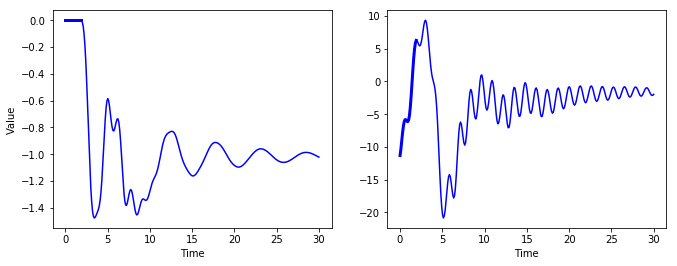

In [24]:
n_iterations = 2000
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)

    sequence1 = [0. for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence1[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence1.append(y_pred[0, -1, 0])

    sequence2 = [time_series(i * resolution + t_min + (t_max-t_min/3)) for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence2[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence2.append(y_pred[0, -1, 0])

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(t, sequence1, "b-")
plt.plot(t[:n_steps], sequence1[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.plot(t, sequence2, "b-")
plt.plot(t[:n_steps], sequence2[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
#save_fig("creative_sequence_plot")
plt.show()

### Deep RNNs
![deep-rnn](pics/deep-rnn.png)
* Built by stacking cells into a *MultiRNNCell()*.

In [25]:
tf.reset_default_graph()

n_inputs = 2
n_neurons = 100
n_layers = 3
n_steps = 5
keep_prob = 0.5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(
    num_units=n_neurons)

print(basic_cell)

multi_layer_cell = tf.contrib.rnn.MultiRNNCell(
    [basic_cell] * n_layers)

print(multi_layer_cell)

# states = tuple (one tensor/layer, = final state of layer's cell)

outputs, states = tf.nn.dynamic_rnn(
    multi_layer_cell, X, dtype=tf.float32)

init = tf.global_variables_initializer()

import numpy.random as rnd
X_batch = rnd.rand(2, n_steps, n_inputs)

with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run(
        [outputs, states], 
        feed_dict={X: X_batch})
    
print(outputs_val.shape)

(2, 5, 100)


### DRNNs: Multiple GPUs
* **TO DO**

### Dropout
* Very deep RNNs = danger of overfit. Use dropout to avoid problem.
* Can apply before or after RNN
* If applying dropout between RNN layers, need to use *DropoutWrapper*.

In [32]:
# apply 50% dropout to inputs of RNN layers
# can apply dropout to outputs via output_keep_prob

tf.reset_default_graph()
from tensorflow.contrib.layers import fully_connected

n_inputs = 1
n_neurons = 100
n_layers = 3
n_steps = 20
n_outputs = 1

keep_prob = 0.5
learning_rate = 0.001

def deep_rnn_with_dropout(X, y, is_training):

    # TF implementation of DropoutWrapper doesn't differentiate
    # between training & testing.
    
    cell = tf.contrib.rnn.BasicRNNCell(
        num_units=n_neurons)
    
    if is_training:
        cell = tf.contrib.rnn.DropoutWrapper(
            cell, input_keep_prob=keep_prob)
    
    #
    #
    
    multi_layer_cell = tf.contrib.rnn.MultiRNNCell(
        [cell] * n_layers)
    
    rnn_outputs, states = tf.nn.dynamic_rnn(
        multi_layer_cell, X, dtype=tf.float32)

    stacked_rnn_outputs = tf.reshape(
        rnn_outputs, [-1, n_neurons])
    
    stacked_outputs = fully_connected(
        stacked_rnn_outputs, n_outputs, activation_fn=None)
    
    outputs = tf.reshape(
        stacked_outputs, [-1, n_steps, n_outputs])

    loss = tf.reduce_sum(
        tf.square(outputs - y))
    
    optimizer = tf.train.AdamOptimizer(
        learning_rate=learning_rate)
    
    training_op = optimizer.minimize(loss)

    return outputs, loss, training_op

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])
outputs, loss, training_op = deep_rnn_with_dropout(X, y, is_training)
init = tf.global_variables_initializer()
saver = tf.train.Saver()


* Dropout, in this code, works during both training & testing (don't want).
* *dropout_wrapper()* doesn't know how to handle this, so you need one graph for training, another for testing.

In [33]:
n_iterations = 2000
batch_size = 50

is_training = True

with tf.Session() as sess:
    if is_training:
        init.run()
        for iteration in range(n_iterations):
            X_batch, y_batch = next_batch(batch_size, n_steps)
            sess.run(
                training_op, 
                feed_dict={X: X_batch, y: y_batch})
            
            if iteration % 100 == 0:
                mse = loss.eval(
                    feed_dict={X: X_batch, y: y_batch})
                
                print(iteration, "\tMSE:", mse)
                
        save_path = saver.save(sess, "/tmp/my_model.ckpt")
        
    else:
        saver.restore(sess, "/tmp/my_model.ckpt")
        
        X_new = time_series(
            np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
        y_pred = sess.run(
            outputs, feed_dict={X: X_new})
        
        plt.title("Testing the model", fontsize=14)
        plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
        plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
        plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
        plt.legend(loc="upper left")
        plt.xlabel("Time")
        plt.show()

0 	MSE: 10428.8
100 	MSE: 314.521
200 	MSE: 152.328
300 	MSE: 155.774
400 	MSE: 100.226
500 	MSE: 80.2064
600 	MSE: 92.3898
700 	MSE: 55.4301
800 	MSE: 50.8537
900 	MSE: 47.1413
1000 	MSE: 57.1007
1100 	MSE: 64.2314
1200 	MSE: 51.3272
1300 	MSE: 51.1612
1400 	MSE: 41.0518
1500 	MSE: 42.267
1600 	MSE: 29.6838
1700 	MSE: 48.4316
1800 	MSE: 46.5584
1900 	MSE: 40.6252


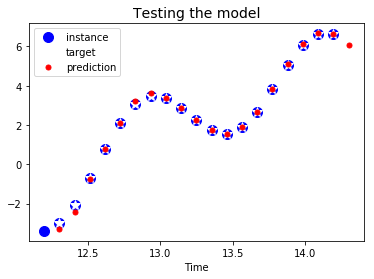

In [35]:
# testing

with tf.Session() as sess:

    saver.restore(sess, "/tmp/my_model.ckpt")
        
    X_new = time_series(
        np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
        
    y_pred = sess.run(
        outputs, feed_dict={X: X_new})
        
    plt.title("Testing the model", fontsize=14)
    plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
    plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
    plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
    plt.legend(loc="upper left")
    plt.xlabel("Time")
    plt.show()

### Training across Many Time Steps
* problem #1: RNNs susceptible to vanishing/exploding gradients issues. Previous tricks will work, but training time = prohibitively long for even modest sequences.
* solution #1: *truncated backprop thru time* (unrolling RNN over limited number of timesteps during training). Works, but *model will not be able to learn long-term patterns*.
* problem #2: memory of early inputs fades away - information lost during each transformation.
* solution #2: using a *long-term memory cell*.

### Long Short-Term Memory (LSTM) Cell
![lstm-cell](pics/lstm-cell.png)
* implemented via *BasicLSTMCell()* instead of *BasicRNNCell()*.

* key feature: net learns what to store (long-term), what to read from, what to throw away.
* Four FC layers - each with unique purposes:
    * main layer: outputs g(t)
    * forget gate: controlled by f(t) - decides which parts of long-term memory to erase
    * input gate: controlled by i(t) - decides which parts of g(t) to add to long-term memory
    * output gate: controlled by o(t) - decides which parts of long-term state should be read & outputted at this time step.

In [36]:
tf.reset_default_graph()

from tensorflow.contrib.layers import fully_connected

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

lstm_cell = tf.contrib.rnn.BasicLSTMCell(
    num_units=n_neurons)

multi_cell = tf.contrib.rnn.MultiRNNCell(
    [lstm_cell]*3)

outputs, states = tf.nn.dynamic_rnn(
    multi_cell, X, dtype=tf.float32)

top_layer_h_state = states[-1][1]

logits = fully_connected(
    top_layer_h_state, 
    n_outputs, 
    activation_fn=None, scope="softmax")

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
    labels=y, logits=logits)

loss = tf.reduce_mean(
    xentropy, name="loss")

optimizer = tf.train.AdamOptimizer(
    learning_rate=learning_rate)

training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(
    logits, y, 1)

accuracy = tf.reduce_mean(
    tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()

In [37]:
states

(LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_2:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_4:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_5:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_6:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_7:0' shape=(?, 150) dtype=float32>))

In [38]:
top_layer_h_state

<tf.Tensor 'rnn/while/Exit_7:0' shape=(?, 150) dtype=float32>

In [39]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((batch_size, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print("Epoch", epoch, "Train accuracy =", acc_train, "Test accuracy =", acc_test)

Epoch 0 Train accuracy = 0.966667 Test accuracy = 0.9403
Epoch 1 Train accuracy = 0.98 Test accuracy = 0.9742
Epoch 2 Train accuracy = 0.993333 Test accuracy = 0.979
Epoch 3 Train accuracy = 0.993333 Test accuracy = 0.9805
Epoch 4 Train accuracy = 1.0 Test accuracy = 0.9854
Epoch 5 Train accuracy = 0.98 Test accuracy = 0.9827
Epoch 6 Train accuracy = 0.993333 Test accuracy = 0.9851
Epoch 7 Train accuracy = 1.0 Test accuracy = 0.9865
Epoch 8 Train accuracy = 1.0 Test accuracy = 0.9887
Epoch 9 Train accuracy = 0.993333 Test accuracy = 0.9871


### Peephole Connections
* Basic LSTM cell: gate controllers only see input x(t) & prev short-term state h(t-1).
* Improvement: let gate peek at long-term state too. Provided with previous long-term state c(t-1) as inputs to forget gate & input gate; current long-term state c(t) added as input to output gate controller.

In [40]:
# Peepholes in TF
lstm_cell = tf.contrib.rnn.LSTMCell(
    num_units=n_neurons, 
    use_peepholes=True)

### Gated Recurrent Unit (GRU) Cell
* Simplified version of LSTM cell
* State vectors merged into single h(t).
* Single gate controller manages forget gate & input gate. (if a memory is to be stored, its location is erased first.)
* No output gate - full state vector output on 
![gru-cell](pics/gru-cell.png)

In [41]:
# in TF
gru_cell = tf.contrib.rnn.GRUCell(num_units=n_neurons)

### Natural Language Processing (NLP)
* Mostly based on RNNs
* See [Word2Vec](https://goo.gl/edArdi) and [Seq2Seq](https://goo.gl/L82gvS) tutorials!
* More: [Chris Olah](https://goo.gl/5rLNTj), [Sebastian Ruder](https://goo.gl/ojJjiE)

### Word Embeddings
* First: need a word representation. Similar words should have similar representations.
* Common sol'n: each word in vocab = small, dense vector of embeddings.

In [42]:
# create embeddings variable. init with random[-1,+1]

vocabulary_size = 50000
embedding_size = 150
embeddings = tf.Variable(
    tf.random_uniform(
        [vocabulary_size, embedding_size], 
        -1.0, 1.0))

* Feeding new sentences to net: replace unknown words, numbers, URLs, etc with predefined tokens. Once a word is known, you can look it up in a dictionary.

In [43]:
train_inputs = tf.placeholder(
    tf.int32, shape=[None]) # from ids...

embed = tf.nn.embedding_lookup(
    embeddings, train_inputs) # ...to embeddings

### English => French Encoder-Decoder Network ([link](https://goo.gl/0g9zWP))
* English inputs, French outputs
* French translations also fed, pushed back one step
* English sentences **reversed** before entry (ensures beginning of sentence is fed last = best for decoder translation)
* Decoder returns score for each word in output vocabulary - softmax turns them into probabilities. Highest probability word is returned.
![encoder-decoder](pics/encoder-decoder.png)

In [44]:
from six.moves import urllib

import errno
import os
import zipfile

WORDS_PATH = "datasets/words"
WORDS_URL = 'http://mattmahoney.net/dc/text8.zip'

def mkdir_p(path):
    """Create directories, ok if they already exist.
    
    This is for python 2 support. In python >=3.2, simply use:
    >>> os.makedirs(path, exist_ok=True)
    """
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

def fetch_words_data(words_url=WORDS_URL, words_path=WORDS_PATH):
    os.makedirs(words_path, exist_ok=True)
    zip_path = os.path.join(words_path, "words.zip")
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(words_url, zip_path)
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    return data.decode("ascii").split()

In [45]:
words = fetch_words_data()
words[:5]

['anarchism', 'originated', 'as', 'a', 'term']

### Build dictionary

In [46]:
from collections import Counter

vocabulary_size = 50000

vocabulary = [("UNK", None)] + Counter(words).most_common(vocabulary_size - 1)
vocabulary = np.array([word for word, _ in vocabulary])

dictionary = {word: code for code, word in enumerate(vocabulary)}

data = np.array([dictionary.get(word, 0) for word in words])

In [47]:
" ".join(words[:9]), data[:9]

('anarchism originated as a term of abuse first used',
 array([5244, 3081,   12,    6,  195,    2, 3135,   46,   59]))

In [48]:
" ".join([vocabulary[word_index] for word_index in [5241, 3081, 12, 6, 195, 2, 3134, 46, 59]])

'anywhere originated as a term of presidency first used'

In [49]:
words[24], data[24]

('culottes', 0)

### Generate batches

In [50]:
import random
from collections import deque

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [51]:
data_index=0
batch, labels = generate_batch(8, 2, 1)

In [52]:
batch, [vocabulary[word] for word in batch]

(array([3081, 3081,   12,   12,    6,    6,  195,  195], dtype=int32),
 ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term'])

In [53]:
labels, [vocabulary[word] for word in labels[:, 0]]

(array([[5244],
        [  12],
        [   6],
        [3081],
        [ 195],
        [  12],
        [   6],
        [   2]], dtype=int32),
 ['anarchism', 'as', 'a', 'originated', 'term', 'as', 'a', 'of'])

### Build the Model

In [54]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.

valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = rnd.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

learning_rate = 0.01

In [55]:
tf.reset_default_graph()

# Input data.
train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

# Look up embeddings for inputs.
init_embeddings = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
embeddings = tf.Variable(init_embeddings)
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

# Construct the variables for the NCE loss
nce_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                        stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Compute the average NCE loss for the batch.
# tf.nce_loss automatically draws a new sample of the negative labels each
# time we evaluate the loss.
loss = tf.reduce_mean(
    tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed,
                   num_sampled, vocabulary_size))

# Construct the Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

# Add variable initializer.
init = tf.global_variables_initializer()

In [56]:
num_steps = 1000 # was 100000?

with tf.Session() as session:
    init.run()

    average_loss = 0
    for step in range(num_steps):
        print("\rIteration: {}".format(step), end="\t")
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # We perform one update step by evaluating the training op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([training_op, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = vocabulary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log_str = "Nearest to %s:" % valid_word
                for k in range(top_k):
                    close_word = vocabulary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)

    final_embeddings = normalized_embeddings.eval()

Iteration: 0	Average loss at step  0 :  260.603485107
Nearest to and: marsh, sipe, vehement, exercises, einer, mrnas, dancer, grendel,
Nearest to called: innuendo, algerian, synthesizing, montgomery, unspoken, elevating, plankton, monochromatic,
Nearest to many: salinas, fuji, trochaic, rubinstein, eln, tintin, lloyd, carbides,
Nearest to about: moreover, congo, choctaws, accomplished, unwieldy, ks, halifax, pac,
Nearest to than: awake, exact, offutt, gloster, pronunciations, delight, tsarina, hopped,
Nearest to or: long, mage, warriors, adhering, sk, clitoridectomy, parenting, vanguard,
Nearest to of: shakespeare, kemp, relax, cul, breakaway, solemnly, mason, mng,
Nearest to when: tolstoy, courtesan, hashes, coursing, evi, ren, diurnal, stimson,
Nearest to four: supermassive, soviet, palatalization, acclaimed, aided, whitney, filtration, lesbians,
Nearest to most: din, hawaii, loch, necronomicon, sunnah, sh, onager, miracles,
Nearest to on: helpers, tangle, heretical, compulsion, unor

### Save final embeddings

In [57]:
np.save("my_final_embeddings.npy", final_embeddings)

### Plot embeddings

In [60]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

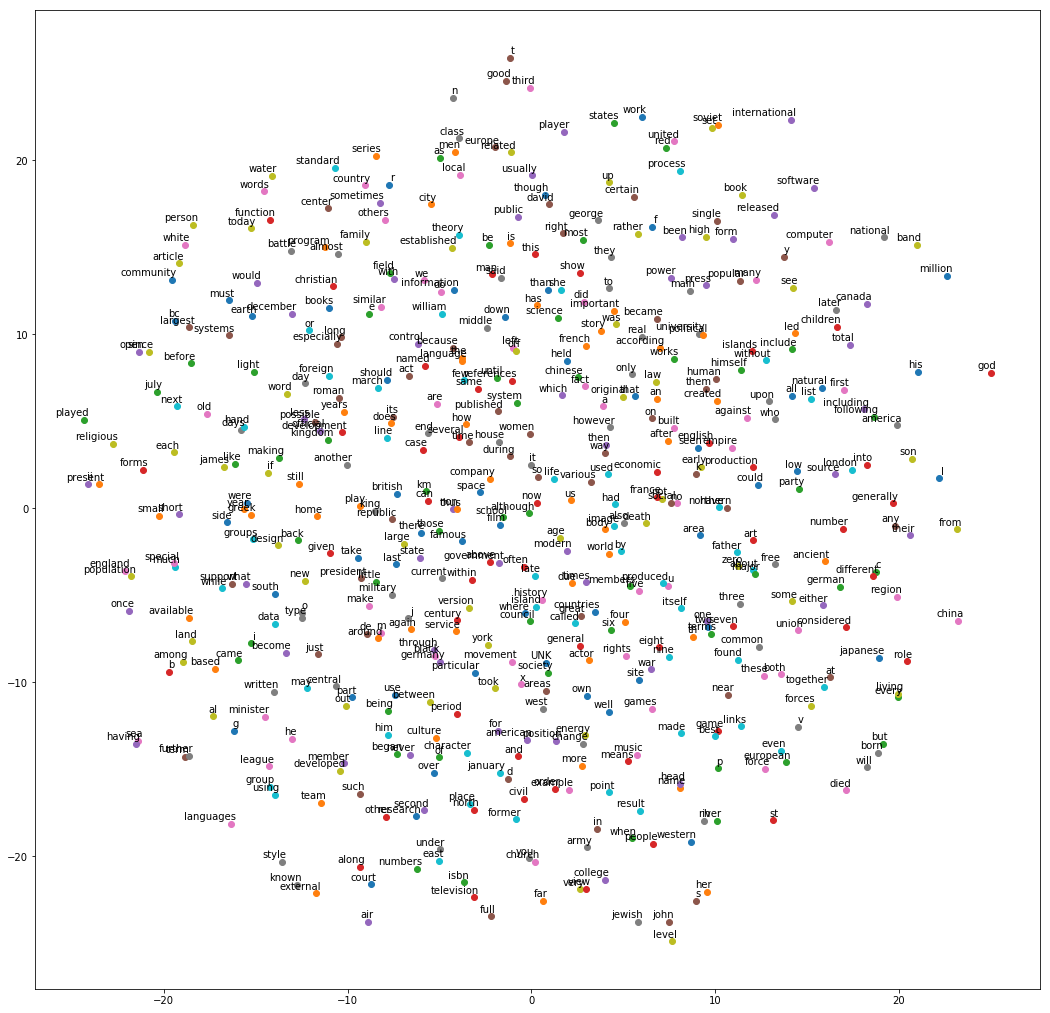

In [62]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [vocabulary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)
